In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import tensorflow as tf
print("TF Version:", tf.__version__)
import math
import matplotlib.pyplot as plt

# Fetch competition dataset
!kaggle competitions download -c titanic

TF Version: 1.15.0
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


# Kaggle Titanic Competition

So the goal is to predict whether, given a set of features of a given passenger aboard the titanic, they would have survived the shipwreck or not.

The training data is comprised of these features for a collection of passengers, and whether they survived or not. Let's take a look at the data.

In [2]:
DATASET = pd.read_csv('train.csv')
TEST_DATASET = pd.read_csv('test.csv')
DATASET.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
DATASET.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
DATASET.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There's data we can completely discard:
- `PassengerId`, `Name`, and `Ticket` are unique identifiers and don't give us any useful information
- `Cabin` is very sparse, about 7/9ths of entries have no cabin number, so we may as well ignore it

In [5]:
from sklearn.preprocessing import OrdinalEncoder

explore = DATASET.copy()
explore = explore.drop(["PassengerId","Name","Cabin","Ticket"], axis=1)

# Encode Sex into two separate categorical columns
explore["Sex"] = OrdinalEncoder().fit_transform(explore[["Sex"]])

explore.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1.0,22.0,1,0,7.2500,S
1,1,1,0.0,38.0,1,0,71.2833,C
2,1,3,0.0,26.0,0,0,7.9250,S
3,1,1,0.0,35.0,1,0,53.1000,S
4,0,3,1.0,35.0,0,0,8.0500,S


In [6]:
explore.corr().Survived.sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Sex        -0.543351
Name: Survived, dtype: float64

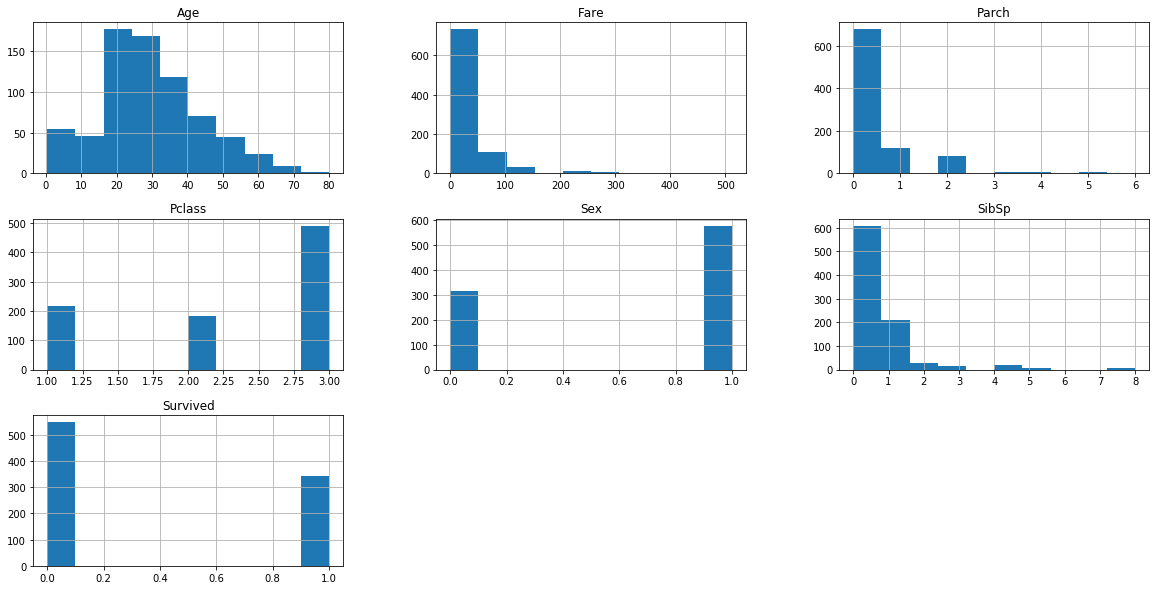

In [7]:
explore.hist(figsize=(20,10))
print()

`Age` is a decent enough contributor, as seen from the matrix and histograms, to need to stratify it. Let's make a good train-test split

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_attribs = ["Age","Fare","Parch","SibSp"]
cat_attribs = ["Sex","Pclass"]

num_pipeline = Pipeline([ 
                         ("imputer", SimpleImputer(strategy="median")),
                         ("std_scaler", StandardScaler()) 
])

pipeline = ColumnTransformer([
                              ("cat", OrdinalEncoder(), cat_attribs),
                              ("num", num_pipeline, num_attribs)
 ])

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

no_labels = DATASET.drop(["Survived"], axis=1)

titanic = pipeline.fit_transform(no_labels)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

TRAIN = None
TEST = None

train, test = next(sss.split(titanic, titanic[:,0]))

TRAIN = np.apply_along_axis(lambda i: titanic[i], 0, train)
TRAIN_LABELS = DATASET.Survived.loc[train].values

TEST = np.apply_along_axis(lambda i: titanic[i], 0, test)
TEST_LABELS = DATASET.Survived.loc[test].values

Will good old logistic regression do?

In [0]:
from sklearn.linear_model import LogisticRegression

model_v1 = LogisticRegression(solver='lbfgs')

model_v1 = model_v1.fit(TRAIN, TRAIN_LABELS)

def eval_model(model):
  train_error = 1 - model.score(TRAIN, TRAIN_LABELS)
  test_error = 1 - model.score(TEST, TEST_LABELS)

  return train_error, test_error

def render_eval(scores):
  train, test = scores
  print("Train Error:",train)
  print("Test Error:",test)

Let's establish a good baseline

In [13]:
render_eval(eval_model(model_v1))

Train Error: 0.1980337078651685
Test Error: 0.23463687150837986


## Improvements
### Experimenting with regularization
Let's try and see how alpha affects our scores

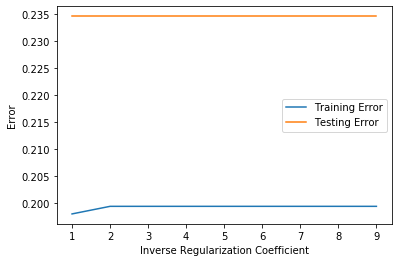

array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667, 0.14285714, 0.125     , 0.11111111])

In [14]:
def ex_regularize(span=(1,10),step=1):
  start, stop = span
  xs = np.arange(start, stop, step)

  results = []

  for ix in range(len(xs)):
    model = LogisticRegression(solver='lbfgs', C=xs[ix])
    model.fit(TRAIN, TRAIN_LABELS)
    results.append(eval_model(model))
  
  return xs, [ a for a,b in results], [ b for a,b in results ]

reg_span, reg_train_errs, reg_test_errs = ex_regularize()

plt.plot(reg_span, reg_train_errs, label="Training Error")
plt.plot(reg_span, reg_test_errs, label="Testing Error")
plt.legend()
plt.xlabel("Inverse Regularization Coefficient")
plt.ylabel("Error")
plt.show()
1 / reg_span

Regularization doesn't really seem to be the limiting factor here unfortunately. But this experiment has shown us something even more important. Our `LogisticRegression` model is having trouble fitting the training data. So we need a larger model. Keras to the rescue.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping

def make_model():
  # Baseline
  model = Sequential([ 
                      Dense(12, input_shape=(6,), activation='relu'),
                      Dense(1, activation='sigmoid') 
                    ])

  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  return model

def decide(yhats, threshold=0.5):
  flip = lambda x: 1. if x >= 0.5 else 0.
  return np.vectorize(flip)(yhats)

def score_model(model):
  return model.evaluate(TEST, TEST_LABELS)[1]

def train_model(
    model, 
    data=(TRAIN,TRAIN_LABELS),
    epochs=100, batch_size=8,
    validation_data=None, validation_split=0.2,
    early_stop=False
    ):
  
  xs,ys = data

  early_stopper = EarlyStopping(
    monitor='val_acc', 
    patience=5,
    restore_best_weights=True
  )

  trace = model.fit(
      xs, ys,
      validation_split=validation_split,
      batch_size=16,
      epochs=epochs,
      verbose=0,
      validation_data=validation_data,
      use_multiprocessing=True,
      callbacks=[early_stopper] if early_stop else []
  )

  return trace.history

def evaluate_deep_model(model, hist, metrics=[]):
  model.summary()

  metrics = ['loss'] + metrics

  epochs = len(hist['loss'])
  xs = np.arange(epochs).astype('int')

  fig, axs = plt.subplots(len(metrics))
  fig.set_size_inches(8,8)
  plt.subplots_adjust(hspace=0.4)

  if type(axs) != type(np.array([])):
    axs = np.array([axs])

  for i,metric in enumerate(metrics):
    met = hist[f"{metric}"]
    val_met = hist[f"val_{metric}"]

    axs[i].set_title(metric)
    axs[i].set_xlabel("Steps")
    axs[i].plot(xs, met, label=f"Train {metric}")
    axs[i].plot(xs, val_met, label=f"Validation {metric}")
    axs[i].legend()
  
  score = score_model(model)
  print("Score:", score)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 12)                84        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 13        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
179/179 [==============================] - 0s 40us/step
Score: 0.7653631281586333


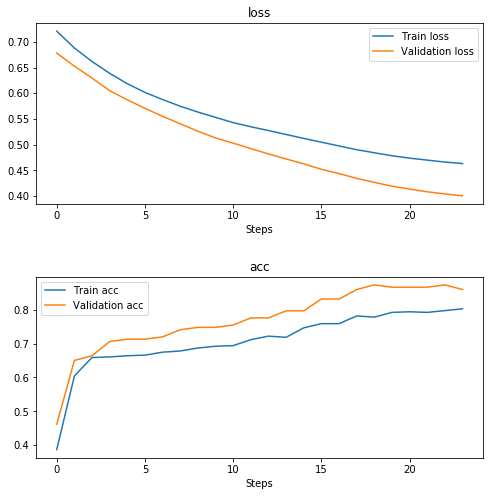

In [33]:
model_v2 = make_model()
model_v2_hist = train_model(model_v2, 
                            (TRAIN, TRAIN_LABELS), 
                            epochs=500,
                            early_stop=True)

evaluate_deep_model(model_v2, model_v2_hist, metrics=['acc'])

This is better. Let's see if cross-validation will help things.

In [0]:
from sklearn.model_selection import StratifiedKFold

def k_fold(X, Y, k=5):
  folder = StratifiedKFold(n_splits=k, shuffle=True, random_state=6)

  datasets = []
  for train_ix, test_ix in folder.split(X, Y):
    train = X[train_ix], Y[train_ix]
    test = X[test_ix], Y[test_ix]

    datasets.append((train, test))
  
  return datasets

def cross_validate(model_gen, k=5):
  folds = k_fold(TRAIN, TRAIN_LABELS, k=k)

  models = { }

  for i,(train,val) in enumerate(folds):
    print(f"Fold: {i+1}/{k}")
    train_x, train_y = train

    model = model_gen()
    hist = train_model(model, (train_x,train_y),
                       validation_data=val,
                       epochs=500, 
                       early_stop=True)

    score = score_model(model)
    print("Score:",score)

    models[score] = (model,hist)

  return models[sorted(models.keys(), reverse=True)[0]]

In [35]:
model_v2, model_v2_hist = cross_validate(make_model, k=2)

Fold: 1/2
179/179 [==============================] - 0s 37us/step
Score: 0.7932960907174222
Fold: 2/2
179/179 [==============================] - 0s 53us/step
Score: 0.7765363125161752


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 12)                84        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 13        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
179/179 [==============================] - 0s 46us/step
Score: 0.7932960907174222


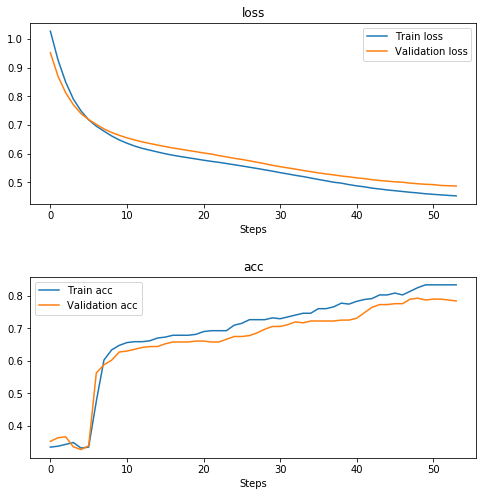

In [36]:
evaluate_deep_model(model_v2, model_v2_hist, metrics=['acc'])

Alright I think we've squeezed enough out of this model. Overfitting is not the problem. Lets make it easier to make and evaluate bigger models, then test things out on those

In [0]:
def fresh_model(arch=[]):
  model = Sequential( arch + [Dense(1, activation='sigmoid')] )

  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

  return model

In [38]:
# First architecture to try

arch_v1 = [ Dense(24, activation='relu'),
            Dense(24, activation='relu') ]

arch_v1_model, arch_v1_hist = cross_validate(lambda: fresh_model(arch_v1), k=10)

Fold: 1/10
179/179 [==============================] - 0s 62us/step
Score: 0.7597765376447966
Fold: 2/10
179/179 [==============================] - 0s 45us/step
Score: 0.7765363101852673
Fold: 3/10
179/179 [==============================] - 0s 42us/step
Score: 0.7597765359798623
Fold: 4/10
179/179 [==============================] - 0s 53us/step
Score: 0.7765363125161752
Fold: 5/10
179/179 [==============================] - 0s 61us/step
Score: 0.7821229023640383
Fold: 6/10
179/179 [==============================] - 0s 48us/step
Score: 0.7653631258277254
Fold: 7/10
179/179 [==============================] - 0s 60us/step
Score: 0.7709497180064964
Fold: 8/10
179/179 [==============================] - 0s 80us/step
Score: 0.7988826828961931
Fold: 9/10
179/179 [==============================] - 0s 45us/step
Score: 0.7765363141811094
Fold: 10/10
179/179 [==============================] - 0s 69us/step
Score: 0.7821229046949462


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 24)                168       
_________________________________________________________________
dense_31 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 25        
Total params: 793
Trainable params: 793
Non-trainable params: 0
_________________________________________________________________
179/179 [==============================] - 0s 51us/step
Score: 0.7653631298235675


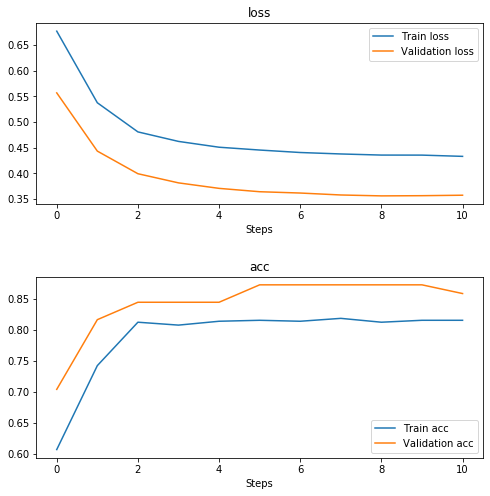

In [39]:
evaluate_deep_model(arch_v1_model, arch_v1_hist, metrics=['acc'])

In [40]:
arch_v1_model.evaluate(TRAIN, TRAIN_LABELS)

712/712 [==============================] - 0s 36us/step


[0.5236831823091829, 0.8117977528089888]

## Sumbission

In [0]:
final_model = arch_v1_model

# Predict Test and save in output file
titanic_test = pipeline.transform(TEST_DATASET)
predictions = decide(final_model.predict(titanic_test).flatten())

xs = list(range(len(predictions)))

output = pd.DataFrame({ 
    'PassengerId': TEST_DATASET['PassengerId'],
    'Survived': predictions.astype('int8')
})

output.to_csv('output.csv', index=False)

In [42]:
# Submit to Kaggle (BE CAREFUL WITH THS!)
!kaggle competitions submit -f output.csv -m "Baseline" titanic

100% 2.77k/2.77k [00:00<00:00, 13.2kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster